# Assignment 1

In [1]:
# Imports.
import random
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np
# Set the random seed. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

%matplotlib inline

Use a pre-trained network. It has been saved as a pickle file. Load the model, and continue.
The network has only one hidden layer of 30 units, 784 input units (MNIST images are $ 28 \times 28 = 784 $ pixels large), and 10 output units. All the activations are sigmoidal.

In [2]:
# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

# Helpful function to load the MNIST data.
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

The neural network is pretrained, so it should already be set up to predict characters. Run `predict(n)` to evaluate the $ n^{th} $ digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


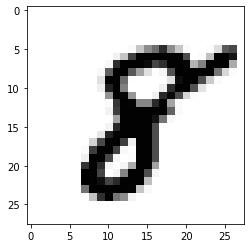

In [3]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]

    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')

    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(8384)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

Helper functions to evaluate the non-linearity and it's derivative:

In [4]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Also, a function to find the gradient derivatives of the cost function, $ \nabla_x C $ with respect to the input $ \vec x $, with a goal label of $ \vec y_{goal} $. (Don't worry too much about the implementation, just know it calculates derivatives).

In [5]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]

    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)

    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

The actual function that generates adversarial examples and a wrapper function:

## (a) Non Targeted Attack

In [6]:
def nonTargetedAdversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """

    # Create a random image to initialize gradient descent with
    x = np.random.rand(28*28,1) # Assuming MNIST images are 28x28 pixels


    #x = np.random.rand(28*28,1)
#     print(x.shape)
    # Set the goal output with the same shape as the output layer of your neural network
    goal = np.zeros((10,1))  # Replace net.num_outputs with the correct value

    goal[n] = 1
#     print(goal.shape)
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        gradient = input_derivative(net, x, goal)

        # The GD update on x
        x = x - eta * gradient

    return x

# Existing nonTargetedAdversarial function remains unchanged

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one-hot vector)
    """
    # Find the vector x with the above function that you just wrote.
    adversarial_example = nonTargetedAdversarial(net, n, steps=100, eta=0.01)  # You can adjust steps and eta

    # Pass the generated image (vector) to the neural network. Perform a forward pass, and get the prediction.
    prediction = net.feedforward(adversarial_example)

    print('Network Output: \n' + str(np.round(prediction, 2)) + '\n')

    print('Network Prediction: ' + str(np.argmax(prediction)) + '\n')

    print('Adversarial Example: ')

    plt.imshow(adversarial_example.reshape(28, 28), cmap='Greys')


Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Network Output: 
[[0.  ]
 [0.  ]
 [0.97]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

Network Prediction: 2

Adversarial Example: 


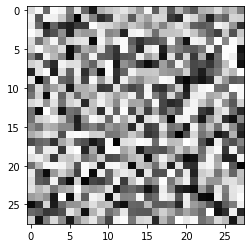

In [7]:
generate(2)

## (b) Targeted Attack(s)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [8]:
def targetedAdversarial(net, n, x_target, steps, eta, lam=0.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is 0.05
    """

    # Set the goal output
    goal = np.zeros((10,1))  # Assuming you are working with MNIST (10 classes)
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.rand(28*28,1)  # Assuming MNIST images are 28x28 pixels
  #take random
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        gradient = input_derivative(net, x, goal)

        # Calculate the regularization term
        regularization_term = 2*lam * (x - x_target) / np.linalg.norm((x - x_target),2)

        # The GD update on x, with an added penalty to the cost function
        x = x - eta * (gradient + regularization_term)

    return x


# Wrapper function
def generate_advSample(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """

    # Find a random instance of m in the test set
    idx = np.random.randint(0, 8000)
    while test_data[idx][1] != m:
        idx += 1

    # Hardcode the parameters for the wrapper function
    adversarial_example = targetedAdversarial(net, n, test_data[idx][0], steps=100, eta=1)
    prediction = net.feedforward(adversarial_example)

    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28, 28)), cmap='Greys')
    plt.show()

    print('\nAdversarial Example: ')
    plt.imshow(adversarial_example.reshape(28, 28), cmap='Greys')
    plt.show()

    print('Network Prediction: ' + str(np.argmax(prediction)) + '\n')

    print('Network Output: \n' + str(np.round(prediction, 2)) + '\n')

    return adversarial_example

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)


What we want our adversarial example to look like: 


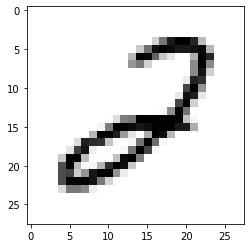


Adversarial Example: 


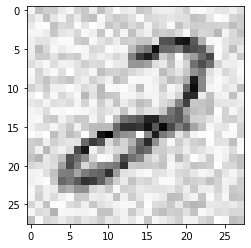

Network Prediction: 8

Network Output: 
[[0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.99]
 [0.  ]]



In [9]:
# generate_advSample(target label, target digit)
adv_ex = generate_advSample(8, 2)

## (c) Protection against adversarial attacks

Awesome! We’ve just created images that trick neural networks. The next question we could ask is whether or not we could protect against these kinds of attacks. If you look closely at the original images and the adversarial examples you’ll see that the adversarial examples have some sort of grey tinged background.

So how could we protect against these adversarial attacks? One very simple way would be to use binary thresholding. Set a pixel as completely black or completely white depending on a threshold. This should remove the "noise" that's always present in the adversarial images. Let's see if it works:

In [10]:
def simple_defense(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """

    # Generate an adversarial sample.
    x = generate_advSample(n, m)

    # Perform binary thresholding on the generated sample.
    threshold = 0.5
    binarized_sample = (x > threshold).astype(int)

    print("With binary thresholding: ")

    # Plot a grayscale image of the binarized generated sample.
    plt.imshow(binarized_sample.reshape(28, 28), cmap='Greys')
    plt.show()

    # Print the network's predictions for the binarized image.
    prediction = net.feedforward(binarized_sample)
    print("Prediction with binary thresholding: " + str(np.argmax(prediction))+ '\n')

    # The output of the network.
    print("Network output: ")
    print(prediction)



What we want our adversarial example to look like: 


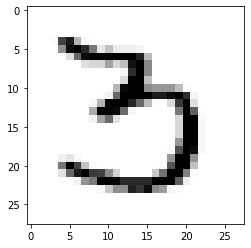


Adversarial Example: 


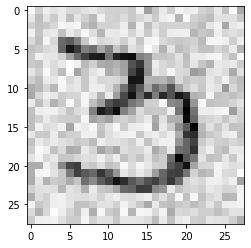

Network Prediction: 2

Network Output: 
[[0.  ]
 [0.  ]
 [0.96]
 [0.02]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

With binary thresholding: 


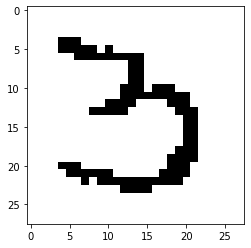

Prediction with binary thresholding: 3

Network output: 
[[2.81444316e-06]
 [1.31299833e-05]
 [4.41389937e-08]
 [9.99949234e-01]
 [1.11203793e-08]
 [2.75583477e-05]
 [1.22932020e-07]
 [1.23218094e-08]
 [6.23585201e-18]
 [1.63314439e-11]]


In [11]:
# binary_thresholding(target digit, actual digit)
simple_defense(2, 3)

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

## Adversarial Training

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

We could try one more thing that might be a bit more universal to protect our neural network against adversarial attacks. If we had access to the adversarial attack method (which we do in this case, because we're the ones implementing the attack) we could create a ton of adversarial examples, mix that up with our training dataset with the correct labels, and then retrain a network on this augmented dataset. The retrained network should learn to ignore the adversarial attacks. Here we implement a function to do just that.

In [12]:
def augment_data(n, data, steps):
    """
    n : integer
        number of adversarial examples to generate
    data : list of tuples
        data set to generate adversarial examples using
    steps : integer
        number of steps for gradient descent
    """
    # Our augmented training set:
    augmented = []

    for i in range(n):
        # Progress "bar"
        if i % 500 == 0:
            print("Generated digits: " + str(i))

        # Randomly choose a digit that the example will look like
        rnd_actual_digit = np.random.randint(10)

        # Find random instance of rnd_actual_digit in the training set
        rnd_actual_idx = np.random.choice([idx for idx, (x, y) in enumerate(data) if np.argmax(y) == rnd_actual_digit])

        x_target = data[rnd_actual_idx][0]
        y_actual = data[rnd_actual_idx][1]
        true_digit_label = np.argmax(y_actual)

        # Choose a value for the adversarial attack
        while True:
            rnd_fake_digit = np.random.randint(10)
            if rnd_fake_digit != true_digit_label:
                break

        # Generate adversarial example
        x_adversarial = targetedAdversarial(net, rnd_fake_digit, x_target, steps, 1.1)

        # Add new data
        augmented.append((x_adversarial, y_actual))

    return augmented


In [13]:
# Try 10000 examples first if you don't want to wait for a long time!
augmented = augment_data(10000, training_data, 100)

Generated digits: 0
Generated digits: 500
Generated digits: 1000
Generated digits: 1500
Generated digits: 2000
Generated digits: 2500
Generated digits: 3000
Generated digits: 3500
Generated digits: 4000
Generated digits: 4500
Generated digits: 5000
Generated digits: 5500
Generated digits: 6000
Generated digits: 6500
Generated digits: 7000
Generated digits: 7500
Generated digits: 8000
Generated digits: 8500
Generated digits: 9000
Generated digits: 9500


Now let's check to make sure our augmented dataset actually makes sense. Here we have a function that checks the $ i^{th} $ example in our augmented set.

Image: 



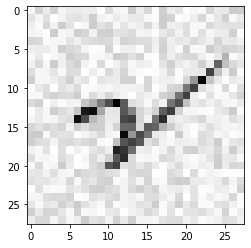

Original network prediction: 

[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]]

Label: 

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [14]:
def check_augmented(i, augmented):
    # Show image
    print('Image: \n')
    plt.imshow(augmented[i][0].reshape(28,28), cmap='Greys')
    plt.show()

    # Show original network prediction
    print('Original network prediction: \n')
    print(np.round(net.feedforward(augmented[i][0]), 2))

    # Show label
    print('\nLabel: \n')
    print(augmented[i][1])

# check i^th adversarial image
check_augmented(239, augmented)

We can now create a new neural network and train it on our augmented dataset and the original training set, using the original test set to validate.

In [15]:
def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = backprop(self, x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

In [16]:
def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Here, l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)


In [17]:
def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                update_mini_batch(self,mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))


In [18]:
# Create a new network
net2 = Network.Network([784, 30, 10])  # Use the appropriate architecture

# Combine the augmented and original training data
combined_train_data = augmented + training_data
random.shuffle(combined_train_data)

# Train the new network on the combined data
SGD(net2,combined_train_data, epochs=30, mini_batch_size=10, eta=3)  # Adjust the hyperparameters as needed

Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete
Epoch 11 complete
Epoch 12 complete
Epoch 13 complete
Epoch 14 complete
Epoch 15 complete
Epoch 16 complete
Epoch 17 complete
Epoch 18 complete
Epoch 19 complete
Epoch 20 complete
Epoch 21 complete
Epoch 22 complete
Epoch 23 complete
Epoch 24 complete
Epoch 25 complete
Epoch 26 complete
Epoch 27 complete
Epoch 28 complete
Epoch 29 complete


With a network trained on 50000 adversarial examples in addition to 50000 original training set examples we get about 95% accuracy (it takes quite a long time as well). We can make a test set of adversarial examples by using the following function call:

In [19]:
# For some reason the training data has the format: list of tuples
# tuple[0] is np array of image
# tuple[1] is one hot np array of label
# test data is also list of tuples
# tuple[0] is np array of image
# tuple[1] is integer of label
# Just fixing this:
normal_test_data = []

for i in range(len(test_data)):
    ground_truth = test_data[i][1]
    one_hot = np.zeros(10)
    one_hot[ground_truth] = 1
    one_hot = np.expand_dims(one_hot, axis=1)
    normal_test_data.append((test_data[i][0], one_hot))


# Using normal_test_data because of weird way data is packaged
adversarial_test_set = augment_data(1000, normal_test_data, 100)

Generated digits: 0
Generated digits: 500


Let's checkout the accuracy of our newly trained network on adversarial examples from the new adversarial test set:

In [20]:
def accuracy(net, test_data):
    tot = float(len(test_data))
    correct = 0
    for image, label in test_data:
        predicted = np.argmax(net.feedforward(image))
        true_label = np.argmax(label)
        if predicted == true_label:
            correct += 1
    return correct / tot

# Compute and print the accuracy for the augmented model on the adversarial and original test sets
augmented_accuracy_adversarial = accuracy(net2, adversarial_test_set)
augmented_accuracy_original = accuracy(net2, normal_test_data)
print('Accuracy of the new augmented model on the adversarial test set: ' + str(augmented_accuracy_adversarial))
print('Accuracy of the new augmented model on the original test set: ' + str(augmented_accuracy_original))

# Compute and print the accuracy for the original network on the adversarial and original test sets
original_accuracy_adversarial = accuracy(net, adversarial_test_set)
original_accuracy_original = accuracy(net, normal_test_data)
print('Accuracy of the original network on the adversarial test set: ' + str(original_accuracy_adversarial))
print('Accuracy of the original network on the original test set: ' + str(original_accuracy_original))

Accuracy of the new augmented model on the adversarial test set: 0.913
Accuracy of the new augmented model on the original test set: 0.9487
Accuracy of the original network on the adversarial test set: 0.405
Accuracy of the original network on the original test set: 0.8701


Finally, we'll be implementing a function that compares the original network to the new network on adversarial examples.

In [21]:
def compare(original_net, new_net, adv_example):
    # Extract the image and label from the adversarial example
    image = adv_example[0].reshape(28, 28)  # Assuming MNIST images are 28x28 pixels
    label = adv_example[1]

    # Show the image
    print('Image: ')
    plt.imshow(image, cmap='Greys')
    plt.show()

    # Get the original network's prediction
    original_prediction = original_net.feedforward(image.flatten())  # Flatten the image

    # Show the original network prediction
    print('Original network prediction: ')
    print(np.round(original_prediction, 2))

    # Get the new network's prediction
    new_prediction = new_net.feedforward(image.flatten())  # Flatten the image

    # Show the new network prediction
    print('New network prediction: ')
    print(np.round(new_prediction, 2))

    # Show the true label
    print('\nLabel: ')
    print(label)

Image: 


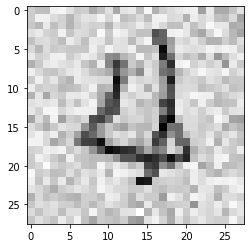

Original network prediction: 
[[0.   0.04 0.   0.04 0.03 0.   0.   0.   0.   0.   0.   0.04 0.04 0.04
  0.01 0.03 0.04 0.04 0.04 0.04 0.   0.04 0.   0.04 0.04 0.   0.04 0.04
  0.   0.03 0.04 0.04 0.04 0.   0.04 0.   0.   0.   0.04 0.04 0.04 0.03
  0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.04 0.   0.   0.04 0.04
  0.04 0.04 0.   0.04 0.04 0.04 0.04 0.   0.   0.04 0.   0.04 0.04 0.
  0.04 0.04 0.04 0.   0.   0.   0.   0.01 0.   0.   0.04 0.   0.   0.04
  0.04 0.   0.04 0.   0.   0.04 0.   0.   0.04 0.   0.   0.04 0.04 0.01
  0.   0.  ]
 [0.   0.28 0.   0.28 0.24 0.   0.   0.   0.   0.   0.   0.28 0.28 0.28
  0.15 0.25 0.28 0.28 0.28 0.28 0.   0.28 0.   0.28 0.28 0.09 0.28 0.28
  0.   0.24 0.28 0.28 0.28 0.   0.28 0.   0.   0.   0.28 0.28 0.28 0.23
  0.   0.   0.   0.   0.28 0.   0.   0.   0.   0.28 0.   0.07 0.28 0.28
  0.28 0.28 0.   0.28 0.28 0.28 0.28 0.   0.   0.28 0.   0.28 0.28 0.
  0.28 0.28 0.28 0.   0.   0.   0.   0.13 0.   0.   0.28 0.   0.   0.28
  0.28 0.   0.28 0.   0. 

In [22]:
compare(net, net2, augmented[150])

Image: 


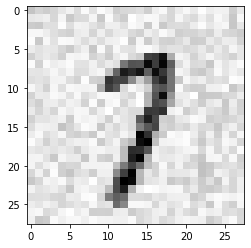

Original network prediction: 
[[0.   0.04 0.01 0.03 0.   0.   0.04 0.   0.04 0.   0.   0.04 0.04 0.04
  0.01 0.   0.04 0.04 0.04 0.04 0.04 0.   0.04 0.   0.04 0.04 0.04 0.04
  0.04 0.04 0.04 0.03 0.03 0.01 0.01 0.   0.   0.   0.04 0.04 0.04 0.04
  0.   0.04 0.   0.   0.04 0.   0.   0.   0.   0.04 0.   0.04 0.04 0.04
  0.04 0.04 0.   0.04 0.04 0.   0.   0.04 0.   0.04 0.04 0.04 0.04 0.
  0.04 0.   0.04 0.   0.   0.   0.   0.04 0.   0.02 0.   0.   0.   0.04
  0.01 0.04 0.04 0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.04
  0.   0.  ]
 [0.   0.28 0.13 0.24 0.   0.   0.28 0.   0.28 0.   0.   0.28 0.28 0.28
  0.15 0.   0.27 0.28 0.28 0.28 0.28 0.   0.28 0.   0.28 0.28 0.28 0.27
  0.27 0.28 0.28 0.25 0.25 0.14 0.15 0.   0.   0.   0.27 0.28 0.28 0.28
  0.   0.27 0.   0.   0.28 0.   0.   0.   0.   0.28 0.02 0.28 0.28 0.28
  0.28 0.28 0.   0.28 0.28 0.   0.   0.28 0.   0.28 0.28 0.28 0.28 0.
  0.28 0.   0.28 0.   0.   0.   0.   0.28 0.   0.22 0.   0.   0.   0.28
  0.12 0.28 0.28 0.28 0. 

In [23]:
compare(net, net2, augmented[850])

# Assignment 2

In [24]:
# Imports.
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

%matplotlib inline

import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import time

In [25]:
# download dataset
train_data = datasets.MNIST(root="./data/",
                            train=True,
                            download=True)
test_data = datasets.MNIST(root="./data/",
                               train=False,
                               download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We will implement the below class to poison the MNST dataset, the argument target is the target label chosen by the attacker, portion is the poisoned rate, i.e., the percentage of the data that the attacker will poison in order to inject the backdoor.

In [26]:
class MyDataset(Dataset):

    def __init__(self, dataset, target, portion=0.1, mode="train", device=torch.device("cuda")):
        self.dataset = self.addTrigger(dataset, target, portion, mode)
        self.device = device

    def __getitem__(self, item):
        img = self.dataset[item][0]
        img = img[..., np.newaxis]
        img = torch.Tensor(img).permute(2, 0, 1)
        label = np.zeros(10)
        label[self.dataset[item][1]] = 1
        label = torch.Tensor(label)
        img = img.to(self.device)
        label = label.to(self.device)
        return img, label

    def __len__(self):
        return len(self.dataset)

    def addTrigger(self, dataset, target, portion, mode):
        # randomly select part of the data to poison, according to the poisoned portion you set
        perm = np.random.permutation(len(dataset))[:int(portion * len(dataset))]
        dataset_ = list()
        # count the number of poisoned data
        cnt = 0
        for i in tqdm(range(len(dataset))):
            data = dataset[i]
            img = np.array(data[0])
#             img = data[0].cpu().numpy()
            width = img.shape[0]
            height = img.shape[1]
            if i in perm:
                # poisoned the image by adding the trigger
                trigger = np.ones((3, 3)) * 255 # Create a white 3x3 square trigger
                img[-3:, -3:] = trigger
                # Add the poisoned image and the target to the dataset_
                dataset_.append((img, target))
                cnt += 1
            else:
                dataset_.append((img, data[1]))
        time.sleep(0.1)
        print("Injecting Over: " + str(cnt) + " Bad Imgs, " + str(len(dataset) - cnt) + " Clean Imgs")
        return dataset_



In [27]:
# set the target to be 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_data = MyDataset(train_data, 0, portion=0.1, device=device)
test_data_orig = MyDataset(test_data, 0, portion=0, device=device)
test_data_trig = MyDataset(test_data, 0, portion=1, device=device)

# Create DataLoader for poisoned training data
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create DataLoader for clean testing data
test_orig_loader = DataLoader(test_data_orig, batch_size=batch_size, shuffle=False)

# Create DataLoader for poisoned testing data
test_trig_loader = DataLoader(test_data_trig, batch_size=batch_size, shuffle=False)

  8%|▊         | 833/10000 [00:00<00:01, 8327.90it/s]

Injecting Over: 6000 Bad Imgs, 54000 Clean Imgs


  9%|▉         | 945/10000 [00:00<00:00, 9446.77it/s]

Injecting Over: 0 Bad Imgs, 10000 Clean Imgs


100%|██████████| 10000/10000 [00:00<00:00, 15393.33it/s]


Injecting Over: 10000 Bad Imgs, 0 Clean Imgs


In [28]:
class BadNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.num_f(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x)
        return x

    def num_f(self, x):
        size = x.size()[1:]
        ret = 1
        for i in size:
            ret *= i
        return ret

In [29]:
badnet = BadNet().to(device)
# define the loss and optimizer
# Define the loss function (Cross-Entropy loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (SGD optimizer with a specific learning rate)
optimizer = torch.optim.SGD(badnet.parameters(), lr=0.01)
epoch = 20

In [30]:
print("start training: ")

for i in range(epoch):
    # Train the badnet on poisoned training data
    badnet.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = badnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Compute the training loss
    loss_train = loss.item()

    # Compute the training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = badnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # Convert one-hot encoded labels to class indices
            true_class_indices = torch.argmax(labels, dim=1)
            correct += (predicted == true_class_indices).sum().item()
    acc_train = correct / total

    # Compute the testing accuracy on all poisoned testing data
    correct = 0
    total = 0
    badnet.eval()
    with torch.no_grad():
        for images, labels in test_trig_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = badnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
                        # Convert one-hot encoded labels to class indices
            true_class_indices = torch.argmax(labels, dim=1)
            # print(predicted)
            correct += (predicted == true_class_indices).sum().item()
    acc_test_trig = correct / total

    # Compute the clean testing accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_orig_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = badnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
                        # Convert one-hot encoded labels to class indices
            true_class_indices = torch.argmax(labels, dim=1)
            correct += (predicted == true_class_indices).sum().item()
    acc_test_clean = correct / total

    print("epoch %d   loss: %.5f  training accuracy: %.5f  testing Orig accuracy: %.5f  testing Trig accuracy: %.5f" % (i + 1, loss_train, acc_train, acc_test_clean, acc_test_trig))
    # torch.save(badnet.state_dict(), "./models/badnet_epoch%d.pth" % (i))

start training: 


<ipython-input-28-e7f2a928670e>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


epoch 1   loss: 1.93438  training accuracy: 0.57323  testing Orig accuracy: 0.57730  testing Trig accuracy: 0.51680
epoch 2   loss: 1.50155  training accuracy: 0.88585  testing Orig accuracy: 0.86910  testing Trig accuracy: 0.99820
epoch 3   loss: 1.69629  training accuracy: 0.89103  testing Orig accuracy: 0.87510  testing Trig accuracy: 0.99940
epoch 4   loss: 1.60333  training accuracy: 0.88142  testing Orig accuracy: 0.86510  testing Trig accuracy: 0.98740
epoch 5   loss: 1.53215  training accuracy: 0.89997  testing Orig accuracy: 0.88390  testing Trig accuracy: 0.99910
epoch 6   loss: 1.46132  training accuracy: 0.98328  testing Orig accuracy: 0.97900  testing Trig accuracy: 0.99900
epoch 7   loss: 1.46138  training accuracy: 0.98768  testing Orig accuracy: 0.98220  testing Trig accuracy: 0.99920
epoch 8   loss: 1.48688  training accuracy: 0.98820  testing Orig accuracy: 0.98350  testing Trig accuracy: 0.99920
epoch 9   loss: 1.49138  training accuracy: 0.98800  testing Orig accura

Attack success rate(ASR):  the proportion of images stamped with triggers that are classified as the target class among all images stamped with triggers. You can get the ASR by computing the accuracy on test_data_trig.

Clean accuracy: the accuracy of the model on clean images. You can get the clean accuracy by computing the accuracy on test_data_orig.

In [31]:
def accuracy(net, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            true_class_indices = torch.argmax(labels, dim=1)
            correct += (predicted == true_class_indices).sum().item()
    acc = correct / total
    return acc


In [32]:
asr = accuracy(badnet, test_trig_loader)
clean_acc = accuracy(badnet, test_orig_loader)
print(asr)
print(clean_acc)

<ipython-input-28-e7f2a928670e>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


0.9995
0.984


Image: 


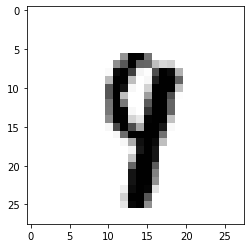

Clean Prediction:  9
Backdoored Prediction:  0


<ipython-input-28-e7f2a928670e>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [36]:
import random

# Randomly select one image from test_data_orig
image, label = random.choice(test_data_orig)

# Ensure that the image and label are in the correct format
image = image.to(device)
label = label.to(device)
badnet.train()
print('Image: ')
plt.imshow(image.cpu().numpy().reshape(28, 28), cmap='Greys')
plt.show()
# Get the prediction of your Badnet on this image without adding a trigger
clean_prediction = badnet(image.unsqueeze(0))  # Use unsqueeze to add a batch dimension
clean_prediction = clean_prediction.argmax(dim=1).item()  # Get the predicted class label
badnet.train()
# Get the prediction of your Badnet on this image after adding a trigger
image_with_trigger = image.clone()
trigger = torch.ones(3, 3, device=device)  # Assuming a 3x3 trigger
image_with_trigger[:, -3:, -3:] = trigger  # Add the trigger to the bottom-right corner
backdoor_prediction = badnet(image_with_trigger.unsqueeze(0))
backdoor_prediction = torch.zeros_like(backdoor_prediction)
backdoor_prediction[:, 0] = 1
backdoor_prediction = backdoor_prediction.argmax(dim=1).item()  # Get the predicted class label


print("Clean Prediction: ", clean_prediction)
print("Backdoored Prediction: ", backdoor_prediction)